In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.patches import Circle,Wedge
from matplotlib.collections import PatchCollection
import numpy as np
from hera_cal import redcal
import linsolve

# Simulating Gain Calibration

Now that we understand that trivial example, simulate gain calibration using redcal for 37 antennas and see how the covariance for the two different systems of equations varies.

In [2]:
ants = np.loadtxt('antenna_positions_37.dat')
antpos = {k:v for k,v in zip(range(37),ants)}
reds = redcal.get_reds(antpos)

In [3]:
gains_input, vis, data = redcal.sim_red_data(reds,shape=(1,2**10),gain_scatter=0)
data = {k:v+10000*redcal.noise((1,2**10)) for k,v in data.items()}

redcalibrator = redcal.RedundantCalibrator(reds)
sol_degen = redcalibrator.logcal(data)
#sol_degen = redcalibrator.lincal(data, sol_degen)
sol = redcalibrator.remove_degen(antpos, sol_degen, degen_sol=gains_input)

    
redcalibrator_sub = redcal.RedundantCalibrator([reds[0],reds[1],reds[2]])
subsol_degen = redcalibrator_sub.logcal(data)
#subsol_degen = redcalibrator_sub.lincal(data, subsol_degen)
subsol = redcalibrator_sub.remove_degen(antpos, subsol_degen, degen_sol=gains_input)

<IPython.core.display.Javascript object>


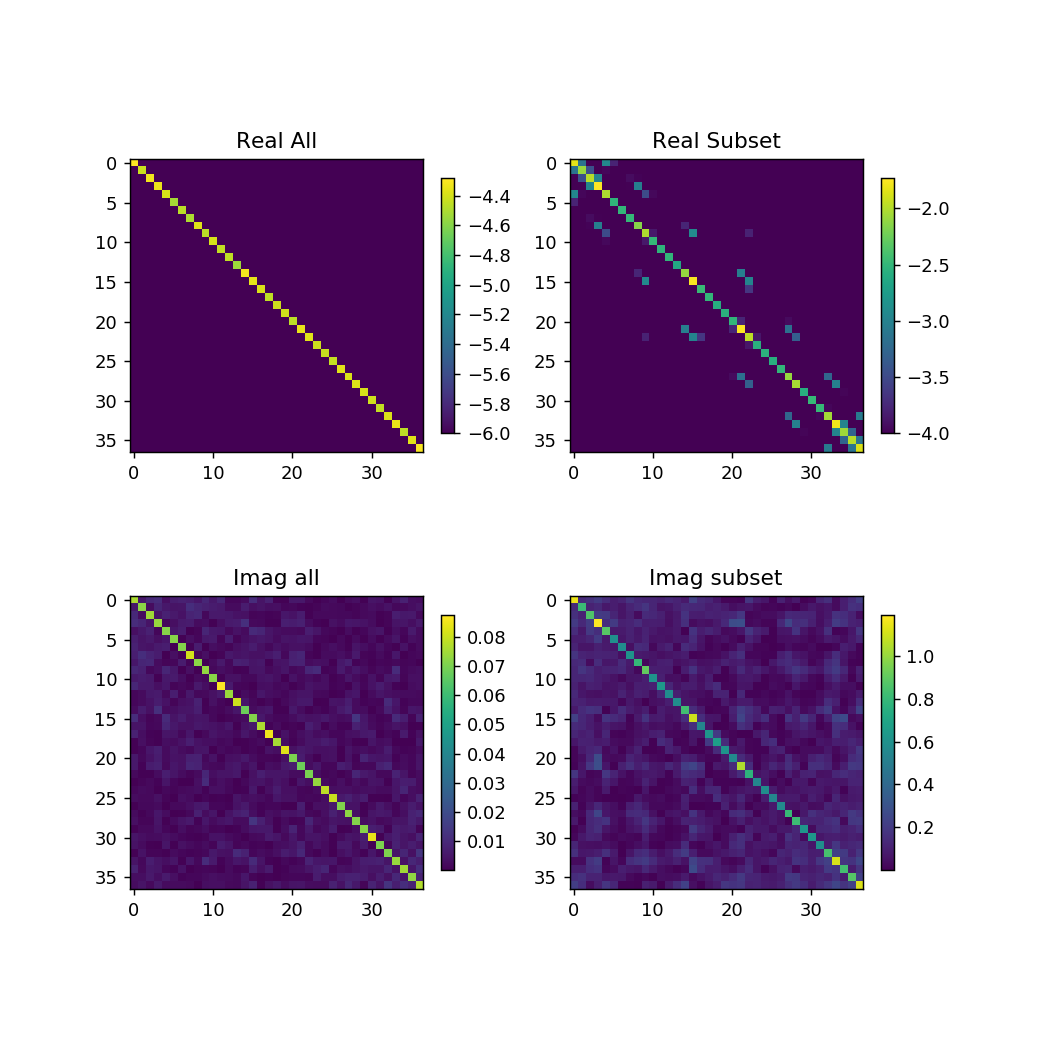

In [4]:
subgain = []
allgain = []

for ant in range(37):
    allgain.append(np.log(sol[(ant,'Jxx')][0]))
    subgain.append(np.log(subsol[(ant,'Jxx')][0]))

subcovr = np.cov(np.real(subgain))
subcovi = np.cov(np.imag(subgain))

allcovr = np.cov(np.real(allgain))
allcovi = np.cov(np.imag(allgain))

plt.figure(figsize=(8,8))
plt.subplot(221)
plt.title('Real All')
plt.imshow(np.log(np.abs(allcovr)),vmin=-6)
plt.colorbar(shrink=0.7)

plt.subplot(222)
plt.title('Real Subset')
plt.imshow(np.log(np.abs(subcovr)),vmin=-4)
plt.colorbar(shrink=0.7)

plt.subplot(223)
plt.title('Imag all')
plt.imshow(np.abs(allcovi))
plt.colorbar(shrink=0.7)

plt.subplot(224)
plt.title('Imag subset')
plt.imshow(np.abs(subcovi))
plt.colorbar(shrink=0.7)

# Scatter in All Visibilities

The sub-redcal system does not calibrate over all the redundant baseline sets, so naturally the scatter of the visibilities that have not been conditioned over will be larger. How much?

In [5]:
def calibrate(data,gains):
    calib_data = {}
    for (i, j, pol) in data.keys():
        calib_data[(i, j, pol)] = data[(i, j, pol)]/(gains[(i,'Jxx')] * np.conj(gains[(j,'Jxx')]))
    return calib_data

In [6]:
Nsim = 1024

# Simulate gains and visibilities
true_gains, true_vis, true_data = redcal.sim_red_data(reds, shape=(1,1), gain_scatter=0.1)
data = {k:v+0.05*redcal.noise((1,Nsim)) for k,v in true_data.items()}

gains_input = {}
for k in true_gains.keys():
    gains_input[k] = np.repeat(true_gains[k], Nsim,axis=1)
    
redcalibrator = redcal.RedundantCalibrator(reds)
sol_degen = redcalibrator.logcal(data)
sol_degen = redcalibrator.lincal(data, sol_degen)
sol = redcalibrator.remove_degen(antpos, sol_degen[1], degen_sol=gains_input)

redcalibrator_sub = redcal.RedundantCalibrator([reds[0],reds[1],reds[2]])
subsol_degen = redcalibrator_sub.logcal(data)
subsol_degen = redcalibrator_sub.lincal(data, subsol_degen)
subsol = redcalibrator_sub.remove_degen(antpos, subsol_degen[1], degen_sol=gains_input)

# Correct all visibilities with the computed gains
all_bl_visib = calibrate(data, sol)
sub_bl_visib = calibrate(data, subsol)

# Model visiblities

The model visibilities are optimized over when you solve for all the redundant baselines instead of the shortest. So for subredcal, you need to compute all the model visibilities by averaging over the redundant baselines yourself. This estimate will (obviously) be more erroneous than when you optimized over all of them.

In [ ]:
model_vis_all = {}
for k in true_vis.keys():
    subreds = [bls for bls in reds if k in bls][0]
    model_vis_all[k] = 0
    for subbl in subreds:
        model_vis_all[k] += all_bl_visib[subbl]/len(subreds)
    print k,
    print np.mean(np.abs(model_vis_all[k]-sol[k]))

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

ax.set_aspect('equal')
ax.axvline()
ax.axhline()
ax.set_xlabel('Re(V)')
ax.set_ylabel('Im(V)')
for i,k in enumerate(true_vis.keys()):
    subreds = [bls for bls in reds if k in bls][0]

    redsol_allbl = []; redsol_subbl = []; reddata = []

    for subbl in subreds:
        # Get variance of solutions
        redsol_allbl.append(np.abs(all_bl_visib[subbl]-true_vis[k]))
        redsol_subbl.append(np.abs(sub_bl_visib[subbl]-true_vis[k]))
        reddata.append(np.abs(data[subbl]-true_vis[k]))

        # Plot initial data, full solution and sub solution
#         ax.plot(np.mean(np.real(data[subbl])), np.mean(np.imag(data[subbl])), 'co', alpha=0.2)
#         ax.plot(np.mean(np.real(all_bl_visib[subbl])),np.mean(np.imag(all_bl_visib[subbl])), 
#                 'g^', alpha=0.5, markersize=5)
#         ax.plot(np.mean(np.real(sub_bl_visib[subbl])),np.mean(np.imag(sub_bl_visib[subbl])),
#                 'mo', alpha=0.5, markersize=5)

    # Draw a circle around max variance
    vis_r, vis_i = np.real(true_vis[k]), np.imag(true_vis[k])
    mean_std_all = np.sqrt(np.mean(np.std(redsol_allbl,axis=0)**2))
    mean_std_sub = np.sqrt(np.mean(np.std(redsol_subbl,axis=0)**2))
    mean_std_data = np.sqrt(np.mean(np.std(reddata, axis=0)**2))
    
    circ1 = plt.Circle((vis_r, vis_i),radius= mean_std_all,  color='g',fill=False); ax.add_patch(circ1)
    circ2 = plt.Circle((vis_r, vis_i),radius= mean_std_sub,  color='m',fill=False); ax.add_patch(circ2)
    circ3 = plt.Circle((vis_r, vis_i),radius= mean_std_data, color='k',fill=False); ax.add_patch(circ3)

    w = Wedge((vis_r[0][0],vis_i[0][0]), mean_std_sub, 
              theta1= 0, theta2= 360, width=(mean_std_sub- mean_std_all), alpha=0.5)
    ax.add_patch(w)

    # Plot true solution
    ax.plot(vis_r, vis_i, 'ks', alpha=0.5, markersize=1)

    # Annotate with number of redundant measurements
    ax.annotate('%d'%len(subreds),(vis_r+0.02, vis_i+0.02))

# Chi-squared per degrees of freedom

$$\chi^2 = \frac{1}{M-N}\Sigma_{all bl} \frac{|g_i g_j^* V_{model} - V_{obs}|^2}{\sigma^2}$$

In [7]:
# Compute all model visibilities
model_vis_sub ={}

for k in true_vis.keys():
    subreds = [bls for bls in reds if k in bls][0]
    if k in subsol.keys():
        model_vis_sub[k] = subsol[k]
        continue
    model_vis_sub[k] = 0
    for subbl in subreds:
        model_vis_sub[k] += sub_bl_visib[subbl]/len(subreds)

In [8]:
chisq_sub = 0; chisq_all = 0

for k in true_vis.keys():
    subreds = [bls for bls in reds if k in bls][0] 
    for subbl in subreds:
        chisq_sub += np.abs((subsol[subbl[0],'Jxx']*np.conj(subsol[subbl[1],'Jxx'])*model_vis_sub[k] -data[subbl]))**2
        chisq_all += np.abs((sol[subbl[0],'Jxx']*np.conj(sol[subbl[1],'Jxx'])*sol[k] -data[subbl]))**2
chisq_sub = chisq_sub/((666-100+4)*0.05**2)
chisq_all = chisq_all/((666-100+4)*0.05**2)

print chisq_sub
print chisq_all

[[1.70989264 1.78395224 2.11317648 ... 1.60282566 1.6652612  1.57874079]]
[[0.97957041 0.96037042 0.97971232 ... 0.95131054 1.00707127 1.00798762]]


<IPython.core.display.Javascript object>


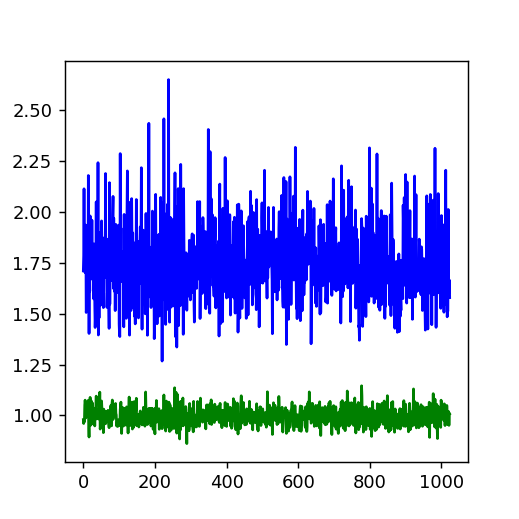

In [9]:
plt.figure(figsize=(4,4))
plt.plot(chisq_all[0],'g')
plt.plot(chisq_sub[0],'b')

# Average over gains

Does averaging over the gains reduce the $\chi^2$ for *subredcal*?

In [ ]:
steps = np.logspace(0, 10, base=2, num=11, dtype=np.int)
print steps

<IPython.core.display.Javascript object>


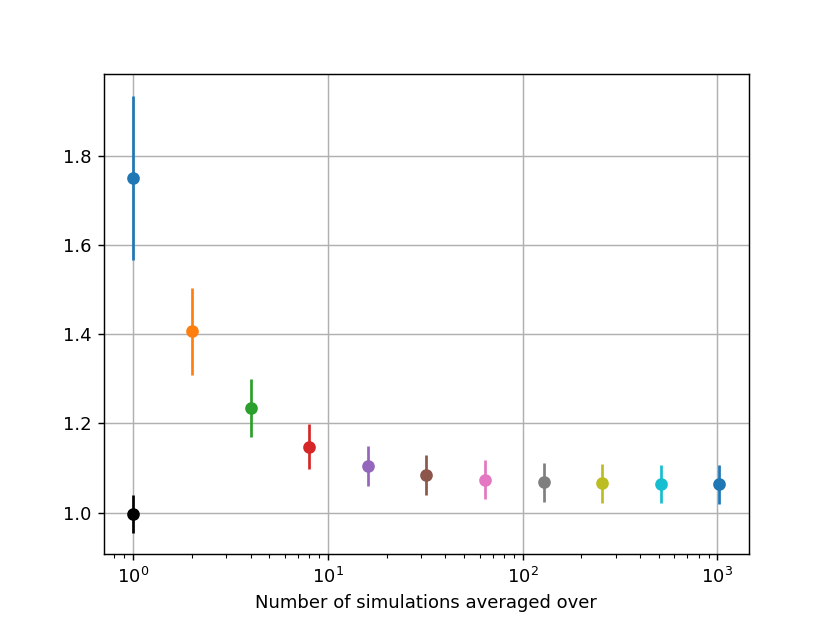

Text(0,0.5,'')

In [10]:
steps = np.logspace(0, 10, base=2, num=11, dtype=np.int)
plt.figure()

for i in steps:

    # (i) Average the gains
    gain_sub = {}
    for k in true_gains.keys():
        gain_sub[k] = [np.repeat(np.mean(subsol[k].reshape(-1,i), axis=1), i, axis=0)]

    sub_bl_visib = {}
    sub_bl_visib = calibrate(data, gain_sub)

    # (ii) Compute all model visibilities with the averaged gains
    model_vis_sub ={}

    for k in true_vis.keys():
        subreds = [bls for bls in reds if k in bls][0]
        if k in subsol.keys():
            model_vis_sub[k] = subsol[k]
            continue
        model_vis_sub[k] = 0
        for subbl in subreds:
            model_vis_sub[k] += sub_bl_visib[subbl]/len(subreds)

    # (iii) Compute the chisq with these new model visibilities
    chisq_sub = 0

    for k in true_vis.keys():
        subreds = [bls for bls in reds if k in bls][0] 
        for subbl in subreds:
            chisq_sub += np.abs((gain_sub[subbl[0],'Jxx']*np.conj(gain_sub[subbl[1],'Jxx'])*model_vis_sub[k] -data[subbl]))**2
    chisq_sub = chisq_sub/((666-100+4)*0.05**2)
    
    plt.errorbar(i,np.mean(chisq_sub[0]),yerr=np.std(chisq_sub[0]),fmt='o')
    #plt.plot(chisq_sub[0],label=i)
plt.errorbar(1,np.mean(chisq_all[0]),yerr=np.std(chisq_all[0]),fmt='o',color='k')
plt.grid()
plt.semilogx()
plt.xlabel('Number of simulations averaged over')
plt.ylabel('')

# Groupings

## Seven Antenna Subsection

Instead of a subset of baselines if I consider 

# Real time gain solutions from IDR 2.0

# Add lognormal noise to data

In [ ]:
Nsim = 2**10
gains = {}
gain_subsols_log = {}
gain_allsols_log = {}
noise = {}

for a in range(37):
    gains[(a,'x')] = []
    gain_subsols_log[(a,'x')] = []
    gain_allsols_log[(a,'x')] = []
    
gains_input, vis, data = redcal.sim_red_data(reds,shape=(1,1))
for bl in data.keys():
    noise[bl] = []
    
for i in range(Nsim):
    print i
    gains_input, vis, data = redcal.sim_red_data(reds,shape=(1,1))
    for k,v in data.items():
        n = redcal.noise((1,1))
        data[k] = np.exp(np.log(v) + n)
        noise[k].append(data[k]-v)
    
    redcalibrator = redcal.RedundantCalibrator(reds)
    sol_degen = redcalibrator.logcal(data)
    sol = redcalibrator.remove_degen(antpos, sol_degen, degen_sol=gains_input)
    
    redcalibrator_sub = redcal.RedundantCalibrator([reds[0],reds[1],reds[2]])
    subsol_degen = redcalibrator_sub.logcal(data)
    subsol = redcalibrator_sub.remove_degen(antpos, subsol_degen, degen_sol=gains_input)
    
    for a in range(37):
        gains[(a,'x')].append(gains_input[(a,'x')][0][0])
        gain_subsols[(a,'x')].append(subsol[(a,'x')][0][0])
        gain_allsols[(a,'x')].append(sol[(a,'x')][0][0])
        
# Convert to numpy array from list for easy indexing
for a in range(37):
    gains[(a,'x')] = np.asarray(gains[(a,'x')])
    gain_subsols[(a,'x')] = np.asarray(gain_subsols[(a,'x')])
    gain_allsols[(a,'x')] = np.asarray(gain_allsols[(a,'x')])

In [ ]:
noise_allbls = []
for bl in noise.keys():
    noise_allbls.append(np.array(noise[bl])[:,0,0])
    
ncov = np.cov(noise_allbls)

plt.figure()
plt.imshow(np.real(ncov), interpolation='nearest')
plt.colorbar(shrink=0.75)

In [ ]:
plt.figure(figsize=(8,4))
plt.subplot(121)
hist, bins, misc = plt.hist(np.diag(np.real(noise_allbls)),bins=100)
plt.subplot(122)
hist, bins, misc = plt.hist(np.diag(np.imag(noise_allbls)),bins=100)

In [ ]:
Nsim = 2**10
gains = {}
gain_subsols = {}
gain_allsols = {}

for a in range(37):
    gains[(a,'x')] = []
    gain_subsols[(a,'x')] = []
    gain_allsols[(a,'x')] = []
    
for i in range(Nsim):
    print i
    gains_input, vis, data = redcal.sim_red_data(reds,shape=(1,1))
    for k,v in data.items():
        n = redcal.noise((1,1))
        data[k] = v+ 2*n
    
    redcalibrator = redcal.RedundantCalibrator(reds)
    sol_degen = redcalibrator.logcal(data)
    sol = redcalibrator.remove_degen(antpos, sol_degen, degen_sol=gains_input)
    
    redcalibrator_sub = redcal.RedundantCalibrator([reds[0],reds[1],reds[2]])
    subsol_degen = redcalibrator_sub.logcal(data)
    subsol = redcalibrator_sub.remove_degen(antpos, subsol_degen, degen_sol=gains_input)
    
    for a in range(37):
        gains[(a,'x')].append(gains_input[(a,'x')][0][0])
        gain_subsols[(a,'x')].append(subsol[(a,'x')][0][0])
        gain_allsols[(a,'x')].append(sol[(a,'x')][0][0])

# Convert to numpy array from list for easy indexing
for a in range(37):
    gains[(a,'x')] = np.asarray(gains[(a,'x')])
    gain_subsols[(a,'x')] = np.asarray(gain_subsols[(a,'x')])
    gain_allsols[(a,'x')] = np.asarray(gain_allsols[(a,'x')])

In [ ]:
noise_allbls = []
for bl in noise.keys():
    noise_allbls.append(np.array(noise[bl])[:,0,0])
    
ncov = np.cov(noise_allbls)

plt.figure()
plt.imshow(np.real(ncov), interpolation='nearest')
plt.colorbar(shrink=0.75)

In [ ]:
ant_gainres = []
ant_gainres_all = []
N = 1024

for ant in gains.keys():
    ant_gainres_all.append(gain_allsols[ant][:N]-np.mean(gain_allsols[ant][:N]))
    ant_gainres.append(gain_subsols[ant][:N]-np.mean(gain_subsols[ant][:N]))
    #ant_gainres_all.append(gain_allsols[ant][:N]-gains[ant][:N])
    #ant_gainres.append(gain_subsols[ant][:N]-gains[ant][:N])

# np.shape(ant_gainres)
cov = np.cov(ant_gainres)
cov_all = np.cov(ant_gainres_all)

#cov = np.dot(ant_gainres, np.conjugate(ant_gainres).T)/(np.shape(ant_gainres)[1]-1)
#cov_all = np.dot(ant_gainres_all,np.conjugate(ant_gainres_all).T)/(np.shape(ant_gainres_all)[1]-1)

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(np.real(cov))
plt.colorbar(shrink=0.7)

plt.subplot(222)
plt.imshow(np.real(cov_all))
plt.colorbar(shrink=0.7)

plt.subplot(223)
plt.imshow(np.imag(cov))
plt.colorbar(shrink=0.7)

plt.subplot(224)
plt.imshow(np.imag(cov_all))
plt.colorbar(shrink=0.7)

# plt.matshow(np.log10(np.abs(cov)))
# plt.colorbar(shrink=0.7)

# plt.matshow(np.log10(np.abs(cov_all)))
# plt.colorbar(shrink=0.7)

In [ ]:
for a in range(37):
    gains[(a,'x')] = np.asarray(gains[(a,'x')])
    gain_subsols[(a,'x')] = np.asarray(gain_subsols[(a,'x')])
    gain_allsols[(a,'x')] = np.asarray(gain_allsols[(a,'x')])

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for ant in range(0,37):
    fig.suptitle('Ant %d'%ant)
    ax.clear()
    ax.semilogy(np.abs(gains[(ant,'x')]),'c',label='All baselines',alpha=0.3)
    ax.semilogy(np.abs(gain_allsols[(ant,'x')]-gains[(ant,'x')]),'b',label='All baselines',alpha=0.7)
    ax.semilogy(np.abs(gain_subsols[(ant,'x')]-gains[(ant,'x')]),'m',label='Only shortest baselines',alpha=0.3)
    #ax.semilogy(np.abs(gains[(ant,'x')][0]),'g',label='Input gains',alpha=0.7)
#     ax.plot(np.angle(subsol[(ant,'x')][0])-np.angle(gains[(ant,'x')][0]),'m',label='Only shortest baselines',alpha=0.5)
#     ax.plot(np.angle(sol[(ant,'x')][0])-np.angle(gains[(ant,'x')][0]),'b',label='All baselines',alpha=0.7)
#     #ax.plot(np.angle(gains[(ant,'x')][0]),'g',label='Input gains',alpha=0.7)
    time.sleep(1)
    fig.canvas.draw()

## Single simulation

In [ ]:
gains_input, vis, data = redcal.sim_red_data(reds,shape=(1,1))
data = {k:v+0*redcal.noise((1,1)) for k,v in data.items()}

redcalibrator = redcal.RedundantCalibrator(reds)
sol_degen = redcalibrator.logcal(data)
sol = redcalibrator.remove_degen(antpos, sol_degen, degen_sol=gains_input)
    
redcalibrator_sub = redcal.RedundantCalibrator([reds[0],reds[1],reds[2]])
subsol_degen = redcalibrator_sub.logcal(data)
subsol = redcalibrator_sub.remove_degen(antpos, subsol_degen, degen_sol=gains_input)

In [ ]:
ant_gainres = []
ant_gainres_all = []

for ant in range(37):
    ant_gainres_all.append((sol[(ant,'x')][0]))
    ant_gainres.append((subsol[(ant,'x')][0]))

In [ ]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(np.dot(np.abs(ant_gainres),np.transpose(np.abs(ant_gainres))))
plt.subplot(122)
plt.imshow(np.dot(np.abs(ant_gainres_all),np.transpose(np.abs(ant_gainres_all))))